<a href="https://colab.research.google.com/github/componavt/wd_book/blob/master/programming_tasks/natural_disasters/volcano_earthquake_clustering_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌋 Volcano-Earthquake Clustering Analysis

This notebook analyzes the grouping of volcanoes and earthquakes based on proximity 🌍, using a KD-tree for efficient neighbor search.  
Instead of matching only pairs, we form **groups** (clusters) where the distance between any two points is below `dist_max`.  

We plot:
- Number of groups
- Average group size
- Variance of group sizes

For the program to work, you need two CSV files generated using SPARQL queries: https://w.wiki/AXz7 and https://w.wiki/AY2R

> "The Earth is the cradle of humanity, but mankind cannot stay in the cradle forever."  
> — Konstantin Tsiolkovsky 🚀

In [58]:
import folium
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
# import pprint # Pretty Print for objects

# Input parameters
dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

f_volcano = "volcanoes_2023.csv"
f_earthquake = "earthquakes_2023.csv"

# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/$f_earthquake

!head -n 3 $f_volcano
!head -n 3 $f_earthquake

--2025-04-26 20:28:53--  https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/volcanoes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76165 (74K) [text/plain]
Saving to: ‘volcanoes_2023.csv.2’

volcanoes_2023.csv. 100%[===================>]  74.38K  --.-KB/s    in 0.02s   

2025-04-26 20:28:53 (3.08 MB/s) - ‘volcanoes_2023.csv.2’ saved [76165/76165]

--2025-04-26 20:28:54--  https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/earthquakes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443.

dist_max=80 km: 1148 groups, average size 3.18, largest group 191, variance 79.05
dist_max=90 km: 1038 groups, average size 3.52, largest group 191, variance 101.47
dist_max=100 km: 931 groups, average size 3.92, largest group 228, variance 158.68
dist_max=110 km: 839 groups, average size 4.36, largest group 242, variance 249.40
dist_max=120 km: 752 groups, average size 4.86, largest group 265, variance 337.41
dist_max=121 km: 746 groups, average size 4.90, largest group 265, variance 340.44
dist_max=122 km: 740 groups, average size 4.94, largest group 267, variance 344.60
dist_max=123 km: 736 groups, average size 4.96, largest group 267, variance 347.94
dist_max=124 km: 732 groups, average size 4.99, largest group 267, variance 350.26
dist_max=125 km: 722 groups, average size 5.06, largest group 267, variance 356.12
dist_max=126 km: 714 groups, average size 5.12, largest group 267, variance 360.24
dist_max=127 km: 703 groups, average size 5.20, largest group 268, variance 366.82
dist_

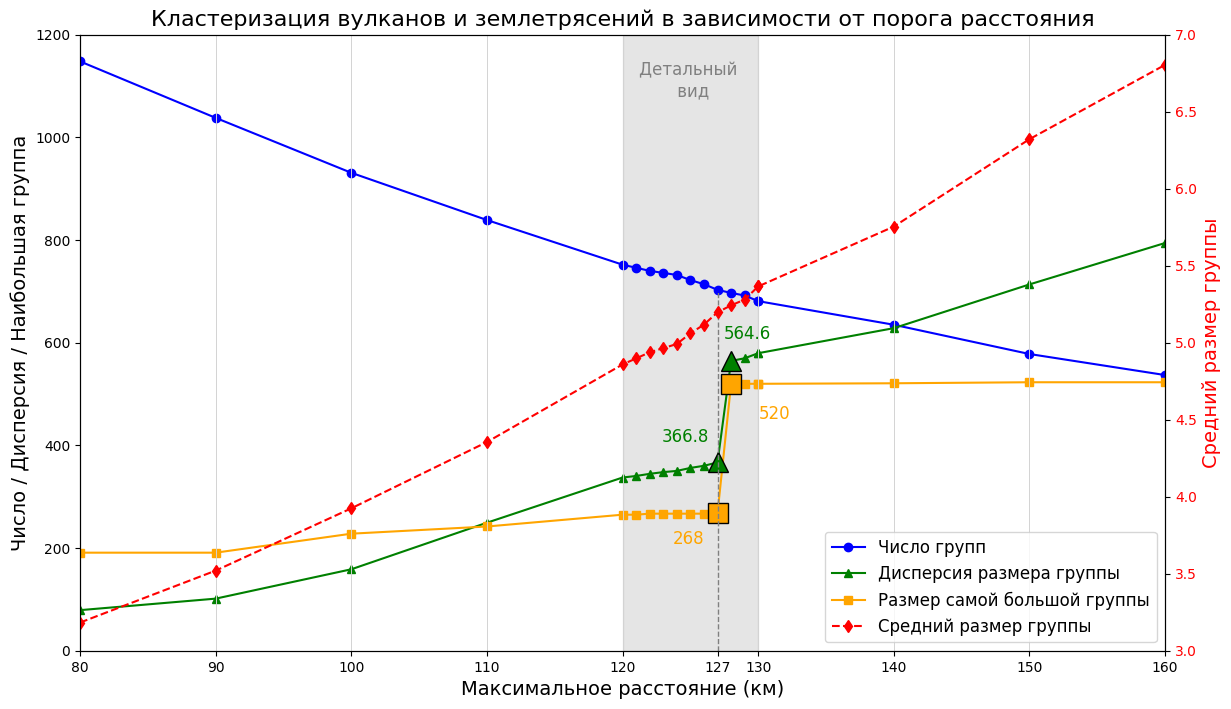

In [67]:
#distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
#distances_max_list = range(80, 170, 10)
# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
distances_max_list = list(range(80, 120, 10)) + list(range(120, 131, 1)) + list(range(130, 170, 10))

import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt

# --- Load volcano and earthquake coordinates ---

def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

# Read volcanoes
with open("volcanoes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

# Read earthquakes
with open("earthquakes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

# --- Combine all points ---
all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

# --- Build KD-Tree ---
tree = KDTree(np.radians(all_coords))  # Use radians for better geodesic approximation

# --- Analysis ---

groups_count_list = []
average_group_size_list = []
group_size_variance_list = []
largest_group_size_list = []

def haversine_distances(coords):
    """Approximate distances matrix on the sphere."""
    from sklearn.metrics.pairwise import haversine_distances
    return haversine_distances(np.radians(coords)) * 6371.0  # Radius of Earth

for dist_max in distances_max_list:
    G = nx.Graph()

    # Add nodes
    for idx, coord in enumerate(all_coords):
        G.add_node(idx, pos=coord, type=types[idx])

    # Find neighbors within dist_max for each point
    for idx, coord in enumerate(all_coords):
        indices = tree.query_ball_point(np.radians(coord), r=dist_max/6371.0)  # r must be in radians
        for neighbor_idx in indices:
            if neighbor_idx != idx:
                G.add_edge(idx, neighbor_idx)

    # Find connected components
    connected_components = list(nx.connected_components(G))
    groups_count = len(connected_components)
    groups_count_list.append(groups_count)

    # Calculate group size metrics
    group_sizes = [len(group) for group in connected_components]
    average_size = np.mean(group_sizes) if group_sizes else 0
    variance_size = np.var(group_sizes) if group_sizes else 0
    largest_size = np.max(group_sizes) if group_sizes else 0

    average_group_size_list.append(average_size)
    group_size_variance_list.append(variance_size)
    largest_group_size_list.append(largest_size)

    print(f"dist_max={dist_max} km: {groups_count} groups, average size {average_size:.2f}, largest group {largest_size}, variance {variance_size:.2f}")

# --- Plot the results with dual Y-axes ---

fig, ax1 = plt.subplots(figsize=(14,8))

# First Y-axis: number of groups, variance, largest group
ax1.plot(distances_max_list, groups_count_list, marker='o', label="Число групп", color='blue')
ax1.plot(distances_max_list, group_size_variance_list, marker='^', label="Дисперсия размера группы", color='green')
ax1.plot(distances_max_list, largest_group_size_list, marker='s', label="Размер самой большой группы", color='orange')
ax1.set_xlabel('Максимальное расстояние (км)', fontsize=14)
ax1.set_ylabel('Число / Дисперсия / Наибольшая группа', fontsize=14, color='black')
ax1.tick_params(axis='y')
ax1.grid(True)

# Create second Y-axis
ax2 = ax1.twinx()
ax2.plot(distances_max_list, average_group_size_list, marker='d', linestyle='--', label="Средний размер группы", color='red')
ax2.set_ylabel('Средний размер группы', fontsize=14, color='red')
ax2.set_ylim(3, 7)  # Fixed scale for better visibility
ax2.tick_params(axis='y', labelcolor='red')



# добавить текстовые подписи к точкам на всех кривых, но только для x=127 и x=128
# 📜 Полный код для аннотаций на графике
# --- Highlight selected points at x = 127 and 128 on green and yellow curves ---

highlight_xs = [127, 128]

# Find indices of x = 127 and x = 128
highlight_indices = [distances_max_list.index(val) for val in highlight_xs]

# Values for green curve (Дисперсия размера группы)
highlight_green_y = [group_size_variance_list[i] for i in highlight_indices]

# Values for yellow curve (Размер самой большой группы)
highlight_yellow_y = [largest_group_size_list[i] for i in highlight_indices]

# Draw larger triangle markers for green curve at selected points
ax1.plot(
    highlight_xs, highlight_green_y,
    marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None', label='_nolegend_'
)

# Draw larger square markers for yellow curve at selected points
ax1.plot(
    highlight_xs, highlight_yellow_y,
    marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None', label='_nolegend_'
)

# Annotate points

# Green curve annotations
ax1.annotate(f"{highlight_green_y[0]:.1f}", xy=(highlight_xs[0], highlight_green_y[0]),
             xytext=(-40, 15), textcoords='offset points', fontsize=12, color='green')
ax1.annotate(f"{highlight_green_y[1]:.1f}", xy=(highlight_xs[1], highlight_green_y[1]),
             xytext=(-5, 16), textcoords='offset points', fontsize=12, color='green')

# Yellow curve annotations
ax1.annotate(f"{highlight_yellow_y[0]:.0f}", xy=(highlight_xs[0], highlight_yellow_y[0]),
             xytext=(-32, -22), textcoords='offset points', fontsize=12, color='orange')
ax1.annotate(f"{highlight_yellow_y[1]:.0f}", xy=(highlight_xs[1], highlight_yellow_y[1]),
             xytext=(20, -25), textcoords='offset points', fontsize=12, color='orange')


# дополнительную тонкую серую вертикальную линию на графике при x=127 (и при x=128)
# Get current ticks
current_xticks = ax1.get_xticks()

# Set ticks manually (including 127)
if 127 not in current_xticks:
    new_xticks = list(current_xticks) + [127]
    ax1.set_xticks(new_xticks)

# Turn off grid, then manually draw grid only for selected ticks
ax1.grid(False)  # Completely turn off auto-grid

# Manually draw grid only at desired ticks (excluding 127)
for tick in current_xticks:
    ax1.axvline(x=tick, color='lightgrey', linestyle='-', linewidth=0.7)

# Draw a short custom vertical line at x=127
ymin, ymax = ax1.get_ylim()
ax1.plot([127, 127], [0, 700], color='grey', linestyle='--', linewidth=1)



# Set exact X and Y limits
ax1.set_xlim(80, 160)
ax1.set_ylim(0, 1200)

# Turn off auto margins
ax1.margins(x=0, y=0)




# Highlight the range 120-130 km with a transparent rectangle
ax1.axvspan(120, 130, color='grey', alpha=0.2)

# Add text annotation above the highlighted area
ax1.text(125, ax1.get_ylim()[1]*0.9, 'Детальный \n вид', ha='center', fontsize=12, color='grey')#,
#         bbox=dict(facecolor='grey', alpha=0.2, edgecolor='none', boxstyle='round,pad=0.2'))




# Combine legends from both axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='lower right', fontsize=12)

plt.title('Кластеризация вулканов и землетрясений в зависимости от порога расстояния', fontsize=16)
plt.show()

пересчёт координат и построения графика


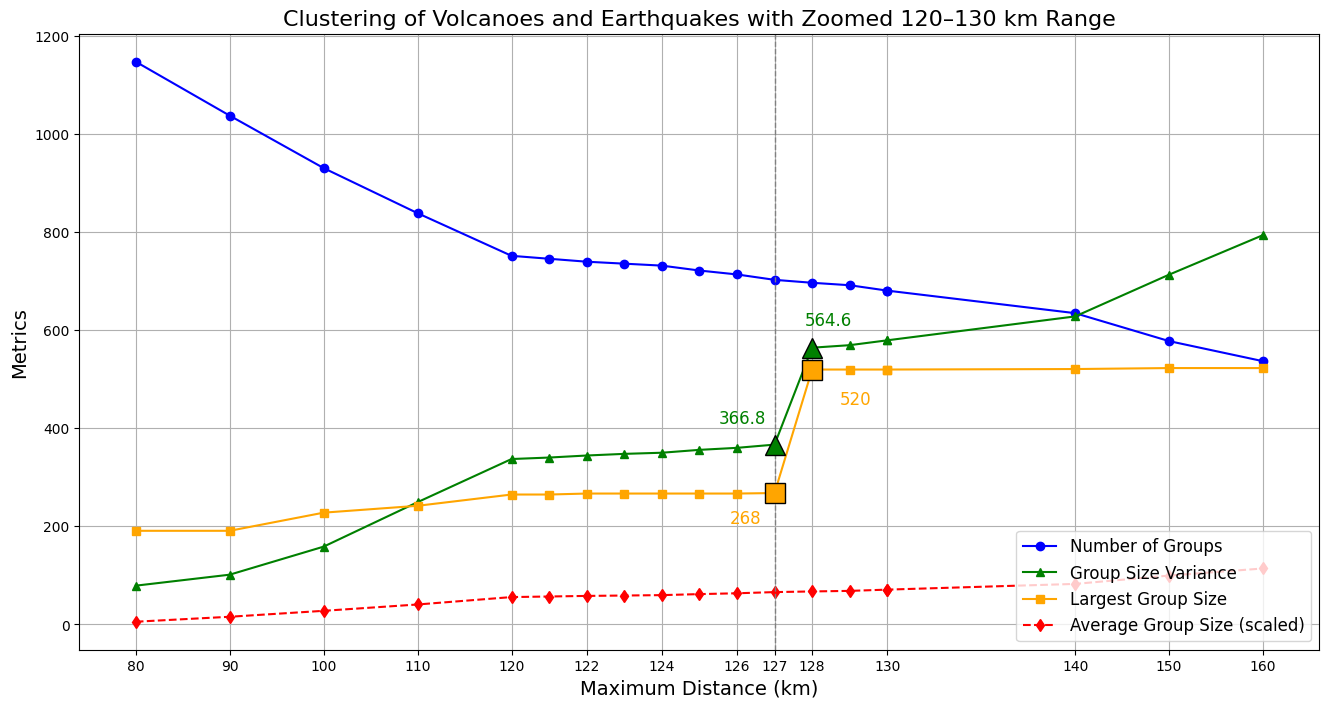

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# --- Generate new "compressed" X axis ---

new_x_list = []
current_x = 0

for x_val in distances_max_list:
    if 80 <= x_val < 120:
        delta = (x_val - 80) * 0.5  # compress
        new_x = delta
    elif 120 <= x_val <= 130:
        delta = (x_val - 120) * 2 + (120 - 80) * 0.5  # expand
        new_x = delta
    else:  # 130 < x_val <= 170
        delta = (x_val - 130) * 0.5 + (130 - 80) * 0.5 + (130 - 120) * 2
        new_x = delta
    new_x_list.append(new_x)

# Save mapping for real x-values
real_to_new_x = dict(zip(distances_max_list, new_x_list))
new_to_real_x = dict(zip(new_x_list, distances_max_list))

# --- Plot using new X axis ---

fig, ax = plt.subplots(figsize=(16,8))

# Plot curves
ax.plot(new_x_list, groups_count_list, marker='o', label="Number of Groups", color='blue')
ax.plot(new_x_list, group_size_variance_list, marker='^', label="Group Size Variance", color='green')
ax.plot(new_x_list, largest_group_size_list, marker='s', label="Largest Group Size", color='orange')

# Plot Average Group Size (scaled manually)
scaled_average_group_size = np.array(average_group_size_list) * 30 - 90
ax.plot(new_x_list, scaled_average_group_size, marker='d', linestyle='--', label="Average Group Size (scaled)", color='red')

# Vertical grey lines at x=127
ax.axvline(real_to_new_x[127], color='grey', linestyle='--', linewidth=1)

# Highlight 127, 128 points
highlight_xs = [127, 128]
highlight_indices = [distances_max_list.index(val) for val in highlight_xs]

highlight_green_y = [group_size_variance_list[i] for i in highlight_indices]
highlight_yellow_y = [largest_group_size_list[i] for i in highlight_indices]

# Draw enlarged markers
ax.plot([real_to_new_x[127]], [highlight_green_y[0]], marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None')
ax.plot([real_to_new_x[128]], [highlight_green_y[1]], marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None')

ax.plot([real_to_new_x[127]], [highlight_yellow_y[0]], marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None')
ax.plot([real_to_new_x[128]], [highlight_yellow_y[1]], marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None')

# Annotate points
ax.annotate(f"{highlight_green_y[0]:.1f}", (real_to_new_x[127], highlight_green_y[0]),
            textcoords="offset points", xytext=(-40, 15), fontsize=12, color='green')
ax.annotate(f"{highlight_green_y[1]:.1f}", (real_to_new_x[128], highlight_green_y[1]),
            textcoords="offset points", xytext=(-5, 16), fontsize=12, color='green')

ax.annotate(f"{highlight_yellow_y[0]:.0f}", (real_to_new_x[127], highlight_yellow_y[0]),
            textcoords="offset points", xytext=(-32, -22), fontsize=12, color='orange')
ax.annotate(f"{highlight_yellow_y[1]:.0f}", (real_to_new_x[128], highlight_yellow_y[1]),
            textcoords="offset points", xytext=(20, -25), fontsize=12, color='orange')

# Set X-ticks: real distances, but placed according to compressed x
selected_xticks = [80, 90, 100, 110, 120, 122, 124, 126, 127, 128, 130, 140, 150, 160]
ax.set_xticks([real_to_new_x[val] for val in selected_xticks])
ax.set_xticklabels(selected_xticks, fontsize=10)

# Labels and grid
ax.set_xlabel('Maximum Distance (km)', fontsize=14)
ax.set_ylabel('Metrics', fontsize=14)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True)

plt.title('Clustering of Volcanoes and Earthquakes with Zoomed 120–130 km Range', fontsize=16)
plt.show()

📜 поиск локального изгиба через вторую производную

Elbow point detected at dist_max ≈ 129 km using second derivative method.


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


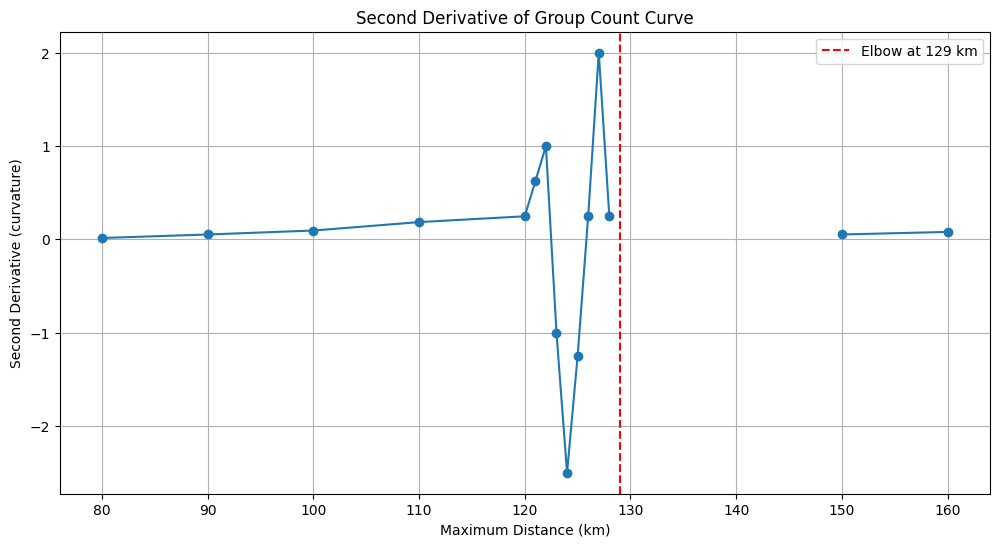

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Assume distances_max_list and groups_count_list are already calculated

# Convert lists to numpy arrays for easier processing
x = np.array(distances_max_list)
y = np.array(groups_count_list)

# Compute first derivative (differences)
dy_dx = np.gradient(y, x)

# Compute second derivative
d2y_dx2 = np.gradient(dy_dx, x)

# Find index of maximum absolute second derivative (largest curvature)
elbow_idx = np.argmax(np.abs(d2y_dx2))
elbow_dist = x[elbow_idx]

print(f"Elbow point detected at dist_max ≈ {elbow_dist} km using second derivative method.")

# --- Optionally, plot second derivative curve to visualize

plt.figure(figsize=(12,6))
plt.plot(x, d2y_dx2, marker='o')
plt.axvline(x=elbow_dist, color='red', linestyle='--', label=f"Elbow at {elbow_dist} km")
plt.title("Second Derivative of Group Count Curve")
plt.xlabel("Maximum Distance (km)")
plt.ylabel("Second Derivative (curvature)")
plt.grid(True)
plt.legend()
plt.show()